# Olist Analysis Report
## Marketing Analysis

In [1]:
# download packages
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
import numpy as np

# download datasets
mql = pd.read_csv('data/olist_marketing_qualified_leads_dataset.csv') # mql list
closed_deals = pd.read_csv('data/olist_closed_deals_dataset.csv') # mqls that converted to Olist customers
order_items = pd.read_csv('data/olist_order_items_dataset.csv') # products sold
sellers = pd.read_csv("data/olist_sellers_dataset.csv") # info about sellers

In [2]:
# convert to datetime and add month label for time series analysis
mql['first_contact_date'] = pd.to_datetime(mql['first_contact_date'])
mql['first_contact_month'] = mql['first_contact_date'].dt.to_period("M")
closed_deals['won_date'] = pd.to_datetime(closed_deals['won_date'])
closed_deals['won_month'] = closed_deals['won_date'].dt.to_period("M")

# transforming dataset for analysis
mf = pd.merge(left=closed_deals, right=mql, on='mql_id', how='left') 
mf_items = pd.merge(left=mf, right=order_items, on='seller_id', how='left')
mf_sellers = pd.merge(left=mf, right=sellers, on='seller_id', how='left')

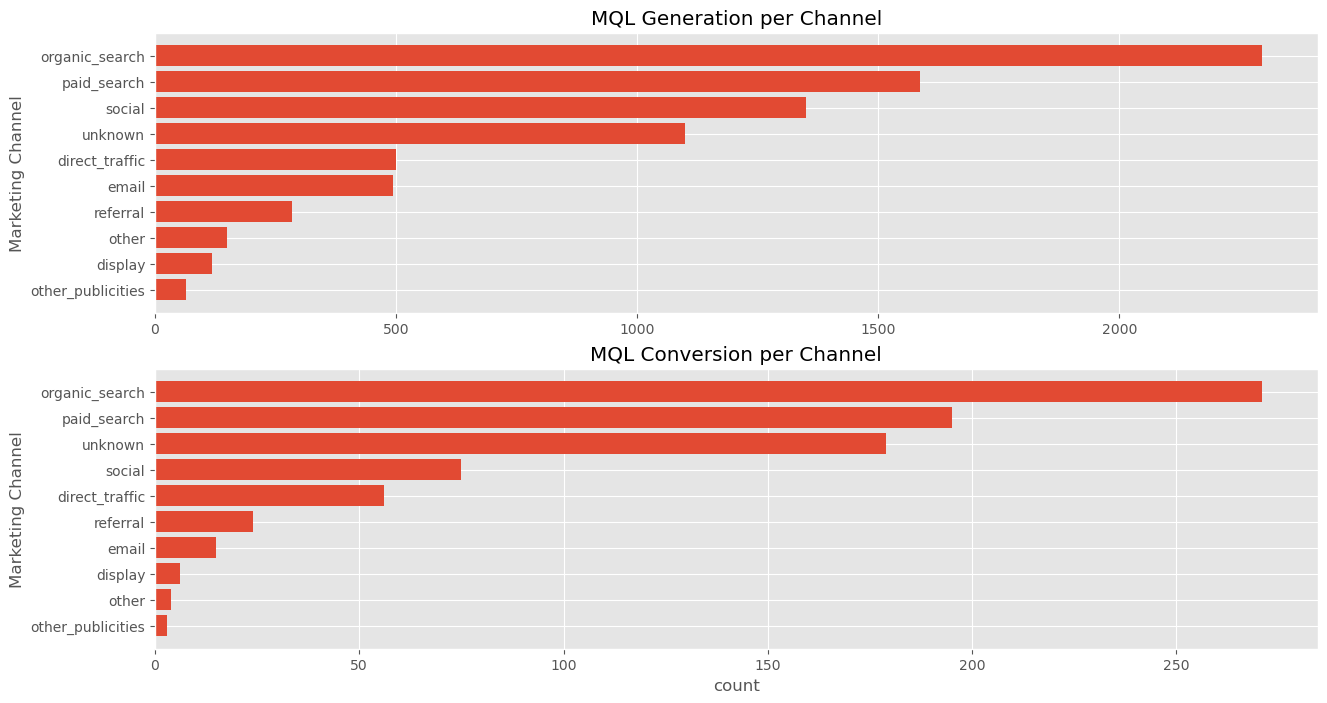

In [3]:
# Volume of MQL per channel
fig, ((ax1),(ax2)) = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
ax1.barh(y=mql['origin'].value_counts().index[::-1], width=mql['origin'].value_counts()[::-1])
ax1.set_title("MQL Generation per Channel")
ax1.set_ylabel("Marketing Channel")
#ax1.set_xlabel("count")
#plt.show()

# volume of converted MQL per channel
ax2.barh(y=mf['origin'].value_counts().index[::-1], width=mf['origin'].value_counts()[::-1])
ax2.set_title("MQL Conversion per Channel")
ax2.set_ylabel("Marketing Channel")
ax2.set_xlabel("count")
# save plot
plt.savefig('figures/mql_gen_con_barchart.png')
plt.show()

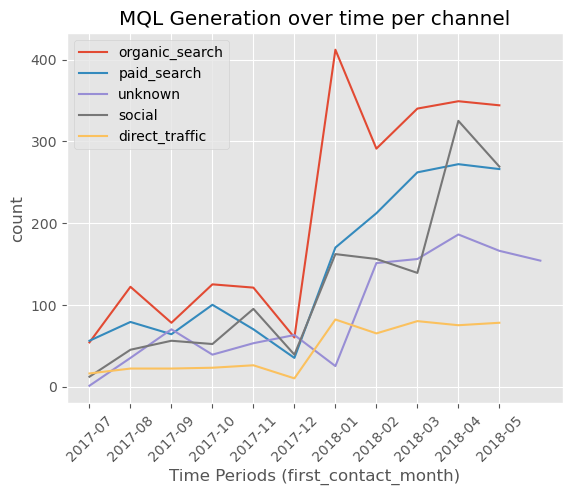

In [4]:
# generate time period per channel (MQL Generation)
channels = ['organic_search', 'paid_search', 'unknown', 'social', 'direct_traffic']
for channel in channels:
    search = mql.loc[mql['origin']==channel]
    monthly_stats = search.groupby('first_contact_month').count()
    counts = monthly_stats['mql_id'].values
    counts_len = len(counts)
    plt.plot(counts, label=channel)
    plt.xticks(ticks=np.linspace(0,counts_len-1, counts_len), labels=monthly_stats.index, rotation=45)
    #if channel == "unknown":
     #   plt.plot(monthly_stats['mql_id'].values[1:], label=channel)
      #  plt.xticks(ticks=np.linspace(0,10,11), labels=monthly_stats.index[1:], rotation=45)
    #else:
     #   plt.plot(monthly_stats['mql_id'].values, label=channel)
      #  plt.xticks(ticks=np.linspace(0,10,11), labels=monthly_stats.index, rotation=45)
plt.legend()
plt.title("MQL Generation over time per channel")
plt.xlabel("Time Periods (first_contact_month)")
plt.ylabel("count")
# save plot
plt.savefig('figures/mql_gen_time_per_channel')
plt.show()

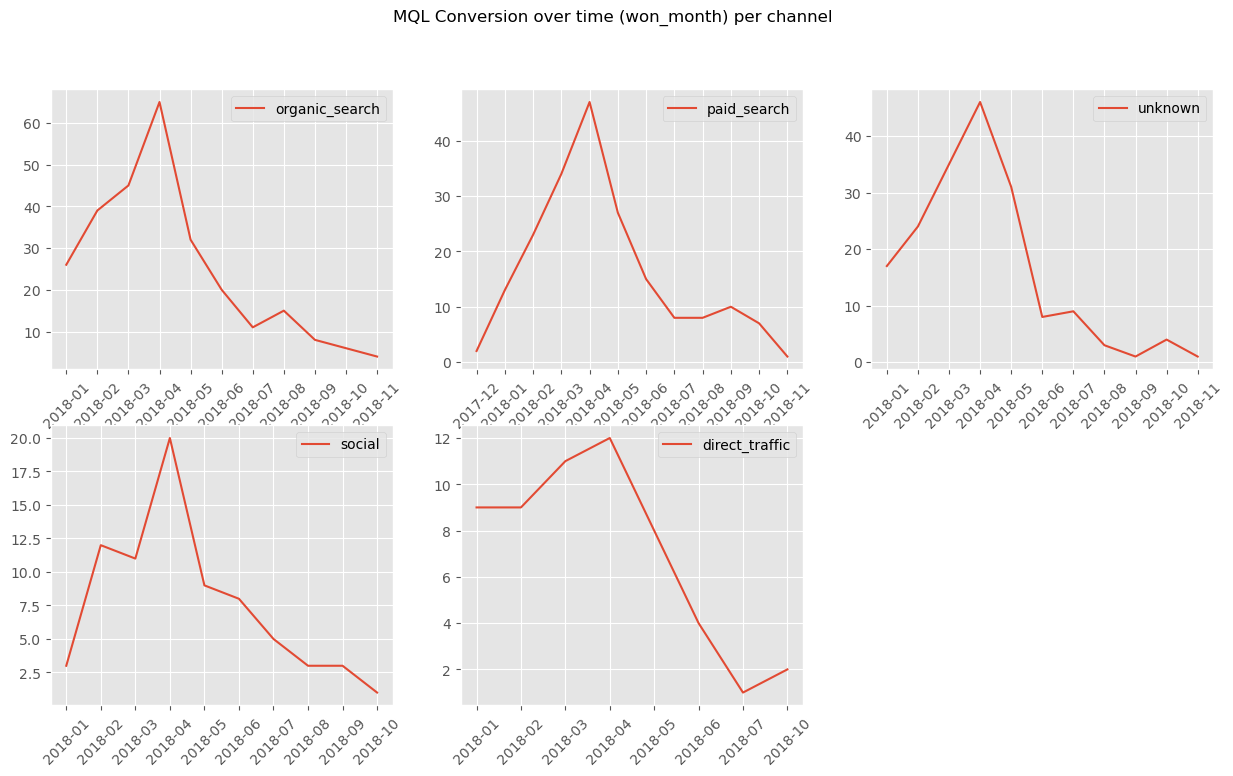

In [5]:
# generate time period per channel (MQL Generation)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = [ax1, ax2, ax3, ax4, ax5]
for channel, axes in zip(channels, axes):
    search = mf.loc[mf['origin']==channel]
    monthly_stats = search.groupby('won_month').count()
    counts = monthly_stats['mql_id'].values
    counts_len = len(counts)
    axes.plot(counts, label=channel)
    axes.set_xticks(ticks=np.linspace(0,counts_len-1, counts_len), labels=monthly_stats.index, rotation=45)
    axes.legend()
ax6.axis('off')
fig.suptitle('MQL Conversion over time (won_month) per channel')
# save plot
plt.savefig('figures/mql_con_time_per_channel.png')
plt.show()

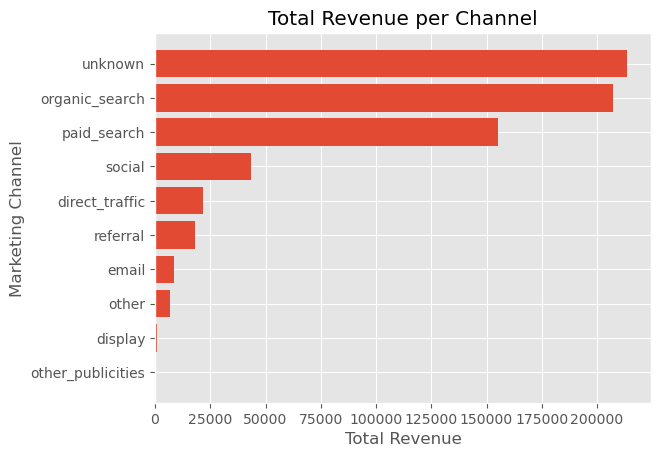

In [6]:
# Produced Revenue by marketing channel
channel_stats = mf_items.groupby(by='origin').sum(numeric_only=True).sort_values(by='price')  # group by marketing channel and compute sum for each column
plt.barh(y=channel_stats.index, width=channel_stats['price'])
plt.title("Total Revenue per Channel")
plt.ylabel("Marketing Channel")
plt.xlabel("Total Revenue")
# save plot
plt.savefig('figures/revenue_per_channel.png', bbox_inches="tight")
plt.show()

## Sales Analysis:

In [7]:
# download data
customers = pd.read_csv('data/olist_customers_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
order_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
products_translation = pd.read_csv('data/product_category_name_translation.csv')

In [8]:
# data pre-process
orders_cleaned = orders[orders['order_status']!='canceled']
products['volume'] = products['product_length_cm']*products['product_height_cm']*products['product_width_cm']
productsTranslated = pd.merge(products, products_translation, on='product_category_name', how='inner')

# merge datasets
order_sales = pd.merge(orders_cleaned, order_payments, on='order_id', how='inner')
orderItems = pd.merge(orders_cleaned, order_items, on='order_id', how='inner')
order_products = pd.merge(orderItems, productsTranslated, on='product_id', how='inner')
order_products = order_products.rename(columns={'product_category_name_english':'product_category'})

In [9]:
# top 10 most popular product categories
order_products['product_category'].value_counts()[0:10]

bed_bath_table           11097
health_beauty             9634
sports_leisure            8590
furniture_decor           8298
computers_accessories     7781
housewares                6915
watches_gifts             5970
telephony                 4527
garden_tools              4328
auto                      4205
Name: product_category, dtype: int64

/var/folders/rz/_nyqj12d6695z910qshyf3jr0000gn/T/ipykernel_39130/3295297544.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top10_avg = order_products.groupby('product_category').mean().loc[top10]


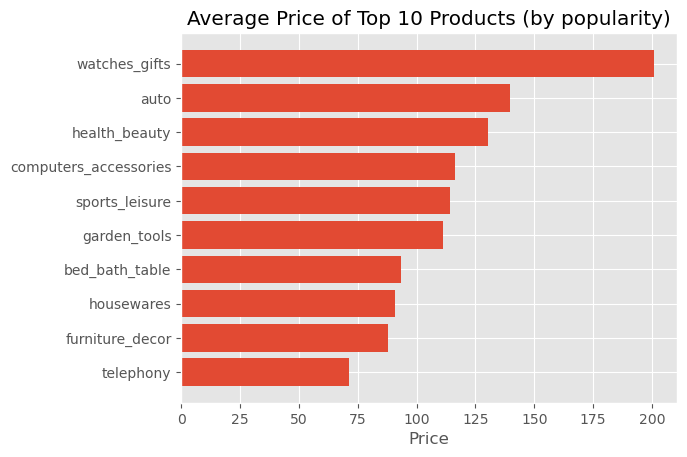

In [11]:
# average price/volume of the top 10 most popular products
top10 = order_products['product_category'].value_counts()[0:10].index
top10_avg = order_products.groupby('product_category').mean().loc[top10]
top10_avg_price = top10_avg['price'].sort_values(ascending=True)
plt.barh(y=top10_avg_price.index,
        width=top10_avg_price)
plt.xlabel("Price")
#plt.ylabel("Products")
plt.title("Average Price of Top 10 Products (by popularity)")
# save plot
plt.savefig('figures/average_price_top10_products.png', bbox_inches="tight")
plt.show()


/var/folders/rz/_nyqj12d6695z910qshyf3jr0000gn/T/ipykernel_39130/909656669.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top10_total = order_products.groupby('product_category').sum().loc[top10, ['price','volume']]


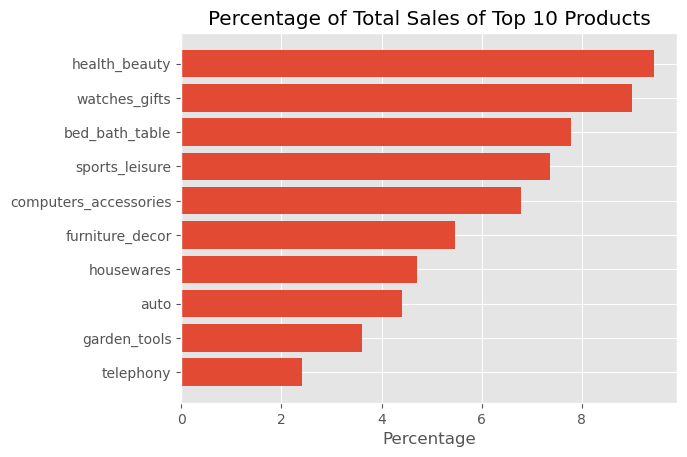

In [12]:
# percentage of total sales of top 10 most popular products
top10_total = order_products.groupby('product_category').sum().loc[top10, ['price','volume']]
top10_total_price = top10_total['price']
top10_total_price_perc = (top10_total_price/order_products['price'].sum())*100
top10_total_price_perc = top10_total_price_perc.sort_values()
plt.barh(y=top10_total_price_perc.index,
        width=top10_total_price_perc)
plt.xlabel('Percentage')
#plt.ylabel("Products")
plt.title("Percentage of Total Sales of Top 10 Products")
# save plot
plt.savefig('figures/total_sales_perc_top10_products.png', bbox_inches="tight")
plt.show()

In [13]:
top10_total_price_perc.sum()

60.98113340829942

## Seller's Profile Analysis:

In [14]:
# download datasets
mql = pd.read_csv('data/olist_marketing_qualified_leads_dataset.csv') # mql list
closed_deals = pd.read_csv('data/olist_closed_deals_dataset.csv') # mqls that converted to Olist customers
order_items = pd.read_csv('data/olist_order_items_dataset.csv') # products sold
sellers = pd.read_csv("data/olist_sellers_dataset.csv") # info about sellers

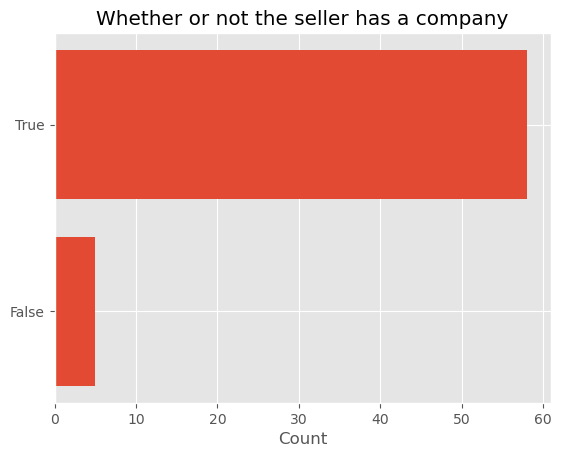

In [15]:
# for categories
plt.barh(y=closed_deals['has_company'].value_counts().index[::-1], width=closed_deals['has_company'].value_counts()[::-1])
plt.yticks(ticks=[1,0], labels=["True", "False"])
plt.xlabel("Count")
plt.title("Whether or not the seller has a company")
# save plot
plt.savefig('figures/has_company.png')
plt.show()

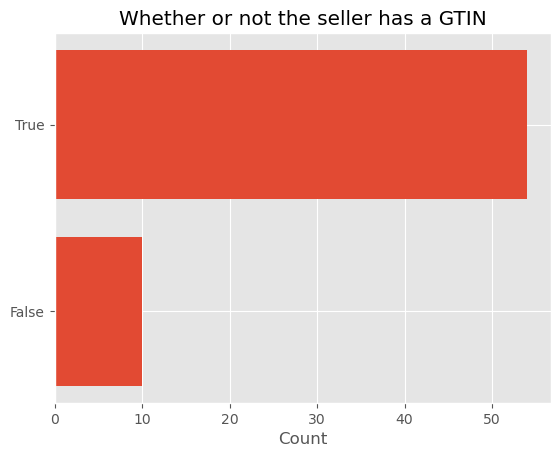

In [16]:
plt.barh(y=closed_deals['has_gtin'].value_counts().index[::-1], width=closed_deals['has_gtin'].value_counts()[::-1])
plt.yticks(ticks=[1,0], labels=["True", "False"])
plt.xlabel("Count")
plt.title("Whether or not the seller has a GTIN")
plt.show()

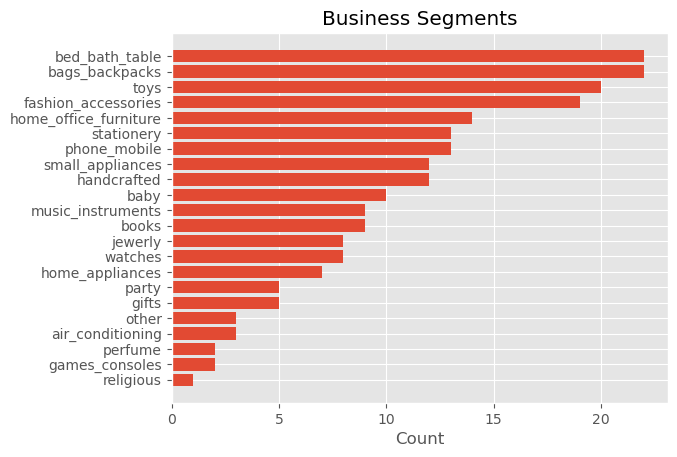

In [17]:
plt.barh(y=closed_deals['business_segment'].value_counts().index[:10:-1], width=closed_deals['business_segment'].value_counts()[:10:-1])
plt.xlabel("Count")
plt.title("Business Segments")
# save plot
plt.savefig('figures/business_segment.png', bbox_inches="tight")
plt.show()

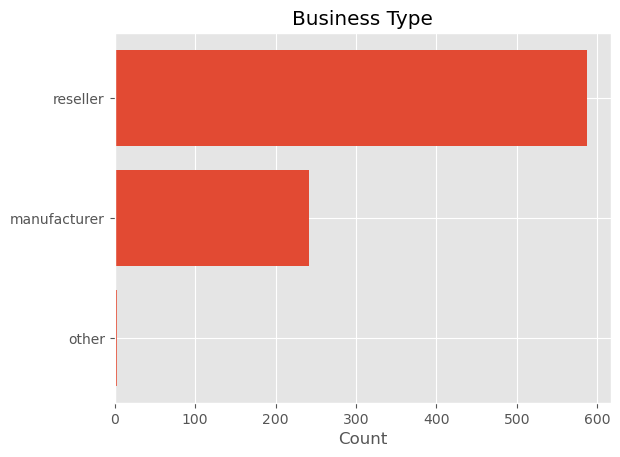

In [18]:
plt.barh(y=closed_deals['business_type'].value_counts().index[::-1], width=closed_deals['business_type'].value_counts()[::-1])
plt.xlabel("Count")
plt.title("Business Type")
plt.show()

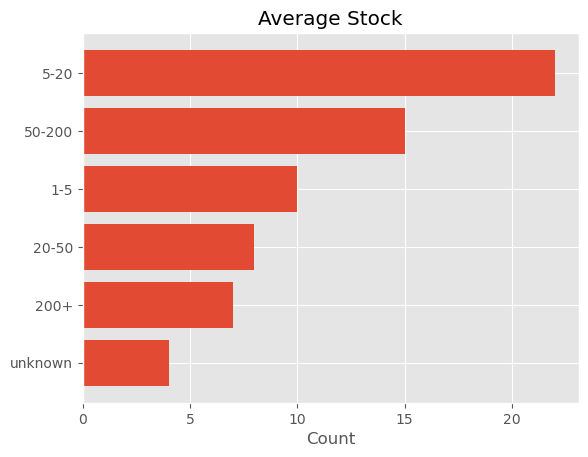

In [19]:
plt.barh(y=closed_deals['average_stock'].value_counts().index[::-1], width=closed_deals['average_stock'].value_counts()[::-1])
plt.xlabel("Count")
plt.title("Average Stock")
plt.show()

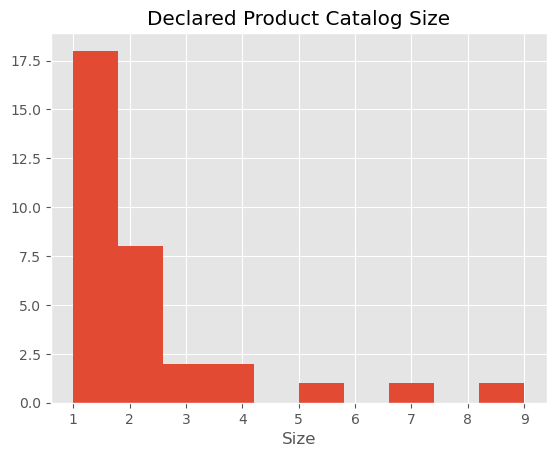

In [20]:
plt.hist(x=closed_deals['declared_product_catalog_size'].value_counts(), bins=10)
plt.xlabel("Size")
plt.title("Declared Product Catalog Size")
plt.show()

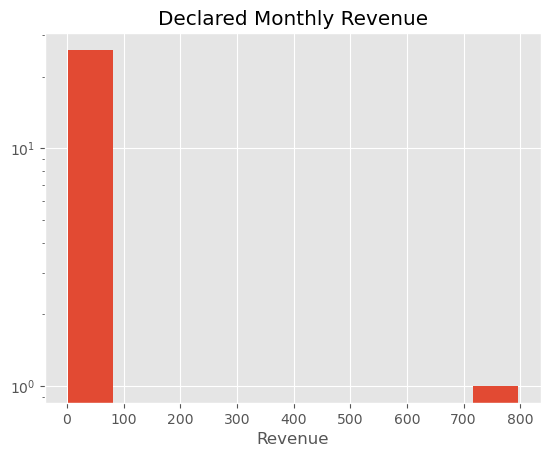

In [21]:
plt.hist(x=closed_deals['declared_monthly_revenue'].value_counts())
plt.yscale('log')
plt.xlabel("Revenue")
plt.title("Declared Monthly Revenue")
plt.show()

In [22]:
closed_deals['declared_monthly_revenue'].value_counts()

0.0           797
100000.0        5
20000.0         3
30000.0         3
10000.0         3
25000.0         3
15000.0         2
120000.0        2
50000.0         2
60000.0         2
300000.0        2
5000.0          2
250000.0        2
210000.0        1
8000000.0       1
40000.0         1
50000000.0      1
4000.0          1
150000.0        1
6.0             1
1000.0          1
180000.0        1
500000.0        1
130000.0        1
6000.0          1
8000.0          1
200000.0        1
Name: declared_monthly_revenue, dtype: int64